In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 81% 49.0M/60.3M [00:01<00:00, 51.0MB/s]
100% 60.3M/60.3M [00:01<00:00, 51.3MB/s]


In [ ]:
!unzip "/content/fer2013.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/sad/Training_65242339.jpg  
  inflating: /content/dataset/train/sad/Training_65267116.jpg  
  inflating: /content/dataset/train/sad/Training_65275626.jpg  
  inflating: /content/dataset/train/sad/Training_6529266.jpg  
  inflating: /content/dataset/train/sad/Training_65329617.jpg  
  inflating: /content/dataset/train/sad/Training_65338712.jpg  
  inflating: /content/dataset/train/sad/Training_65338797.jpg  
  inflating: /content/dataset/train/sad/Training_65387162.jpg  
  inflating: /content/dataset/train/sad/Training_65404494.jpg  
  inflating: /content/dataset/train/sad/Training_65426218.jpg  
  inflating: /content/dataset/train/sad/Training_65430136.jpg  
  inflating: /content/dataset/train/sad/Training_65437377.jpg  
  inflating: /content/dataset/train/sad/Training_6545735.jpg  
  inflating: /content/dataset/train/sad/Training_65463385.jpg  
  inflating: /content/dataset/train/sad/Training_654739

In [ ]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from PIL import Image
import seaborn as sns

In [ ]:
# Importing Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

#Data preprocessing

In [ ]:
train_directory="/content/dataset/train"
validation_directory="/content/dataset/test"
CLASS_NAMES=["angry","disgust","fear","happy","neutral","sad","surprise"]

CONFIGURATION={
    "BATCH_SIZE":32,
    "IM_SIZE":256,
    "CLASS_NAMES": ["angry","disgust","fear","happy","neutral","sad","surprise"],
    "NUM_CLASSES": 7,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
}

In [ ]:
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,

)

Found 28709 files belonging to 7 classes.


In [ ]:
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,

)

Found 7178 files belonging to 7 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [187., 187., 187.],
         [187., 187., 187.],
         [187., 187., 187.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [187., 187., 187.],
         [187., 187., 187.],
         [187., 187., 187.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [187., 187., 187.],
         [187., 187., 187.],
         [187., 187., 187.]],

        ...,

        [[204., 204., 204.],
         [204., 204., 204.],
         [204., 204., 204.],
         ...,
         [206., 206., 206.],
         [206., 206., 206.],
         [206., 206., 206.]],

        [[204., 204., 204.],
         [204., 204., 204.],
         [204., 204., 204.],
         ...,
         [206., 206., 206.],
         [206., 206., 206.],
       

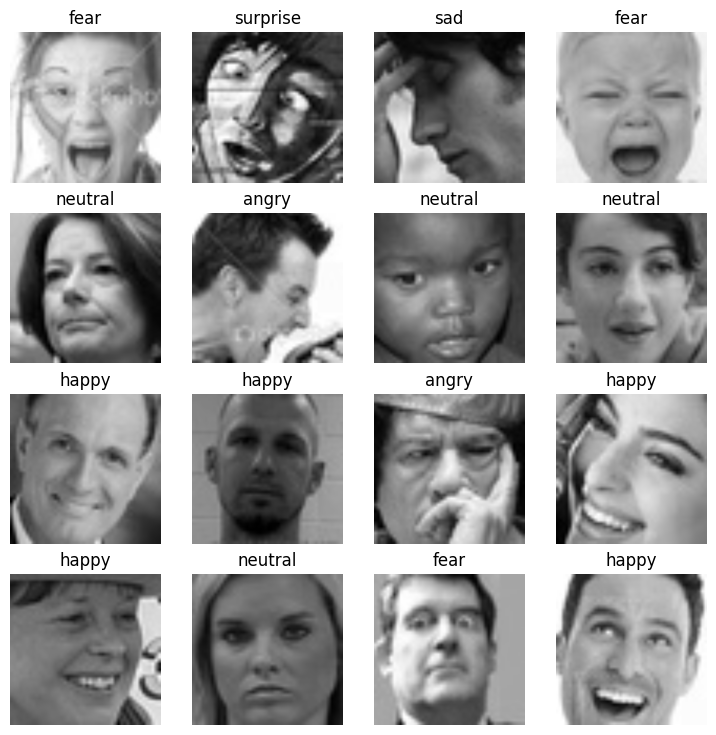

In [ ]:
plt.figure(figsize = (9,9))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [ ]:
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [ ]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [ ]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset=(
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers=tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

In [ ]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [ ]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

#Transfer learning with EfficientNet B40

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [ ]:
model2 = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#freezing the layer
model2.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    model2,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,646,054 (74.94 MB)

 Trainable params: 1,970,183 (7.52 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

In [ ]:
metrices=[CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

In [ ]:
pretrained_model.compile(
    loss='categorical_crossentropy',
    optimizer = Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    metrics=metrices)

In [ ]:
history=pretrained_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=1,
)

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 388s 375ms/step - accuracy: 0.4121 - loss: 1.6652 - top_k_accuracy: 0.6073 - val_accuracy: 0.4921 - val_loss: 1.3802 - val_top_k_accuracy: 0.6987
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 294s 327ms/step - accuracy: 0.5019 - loss: 1.3173 - top_k_accuracy: 0.7043 - val_accuracy: 0.5312 - val_loss: 1.2878 - val_top_k_accuracy: 0.7240
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 308s 342ms/step - accuracy: 0.5171 - loss: 1.2611 - top_k_accuracy: 0.7211 - val_accuracy: 0.5294 - val_loss: 1.2642 - val_top_k_accuracy: 0.7304
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 290s 323ms/step - accuracy: 0.5346 - loss: 1.2335 - top_k_accuracy: 0.7358 - val_accuracy: 0.5343 - val_loss: 1.2619 - val_top_k_accuracy: 0.7357
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 302s 336ms/step - accuracy: 0.5428 - loss: 1.2080 - top_k_accuracy: 0.7437 - val_accuracy: 0.5443 - val_loss: 1.2259 - val_top_k_accuracy: 0.7360
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 288s 321ms/step - accuracy: 0.

In [ ]:
pretrained_model.evaluate(train_dataset)

898/898 ━━━━━━━━━━━━━━━━━━━━ 110s 122ms/step - accuracy: 0.6907 - loss: 0.8527 - top_k_accuracy: 0.8561


[0.8156003952026367, 0.7026367783546448, 0.8675328493118286]

In [ ]:
pretrained_model.evaluate(validation_dataset)

225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - accuracy: 0.5754 - loss: 1.3002 - top_k_accuracy: 0.7555


[1.302961826324463, 0.5718863010406494, 0.7570353746414185]

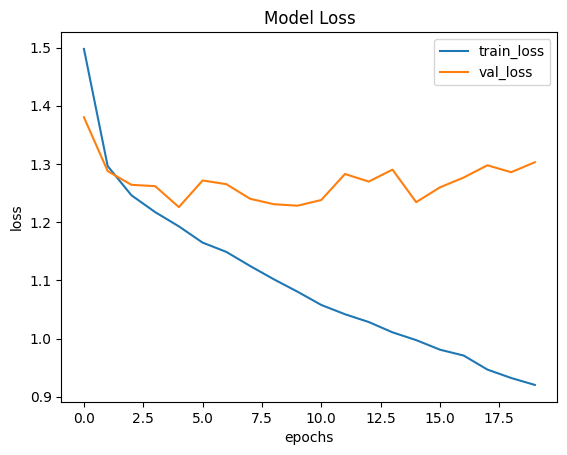

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

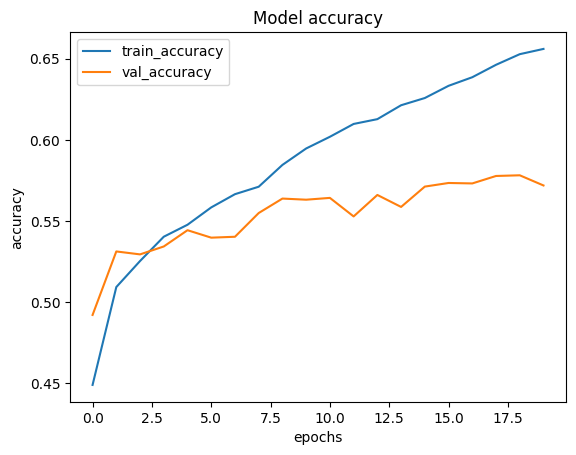

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

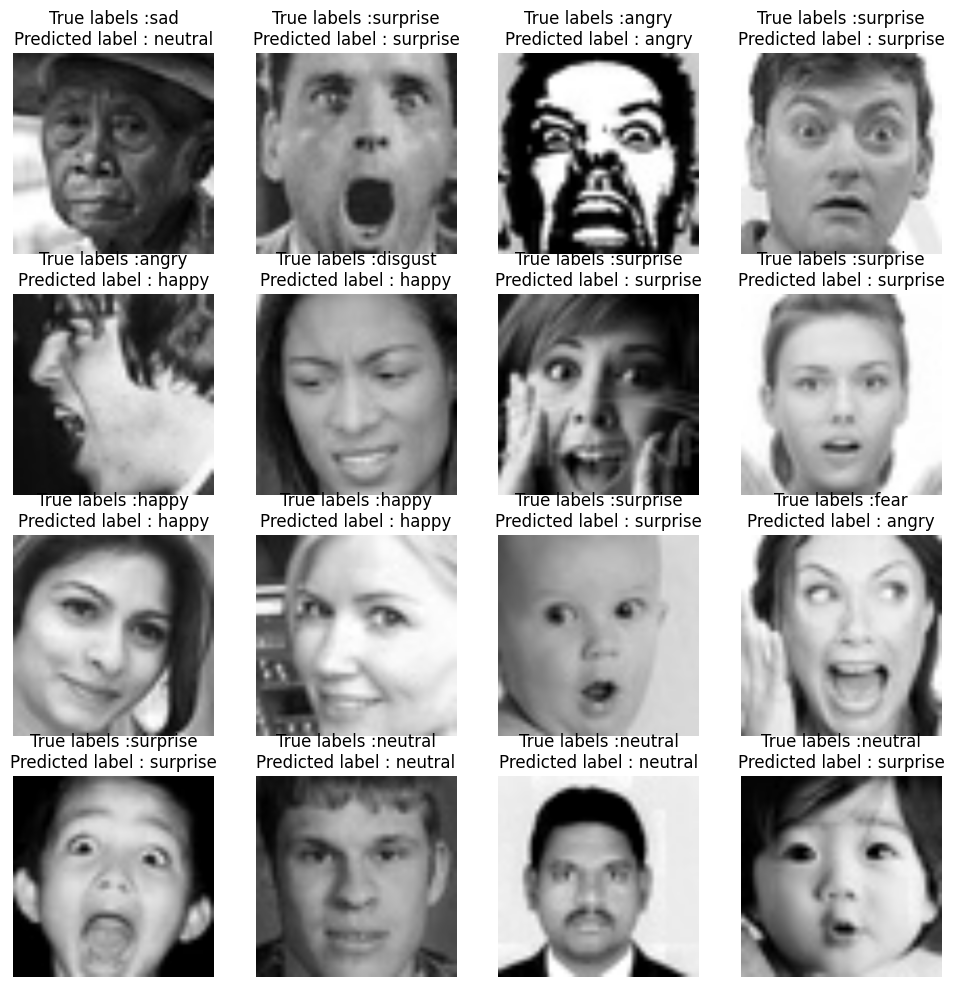

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title("True labels :" + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()] + "\n" + "Predicted label : " + CLASS_NAMES[tf.argmax(pretrained_model(tf.expand_dims(images[i], axis = 0)), axis=-1).numpy()[0]])
    plt.axis("off")